In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from theano import shared
from utils import calc_sup_inf_bay

# es. fit pochi punti

In [ ]:
x = np.array([4., 8., 12.])
y = [2.,3., 4.]


(-6, 18)

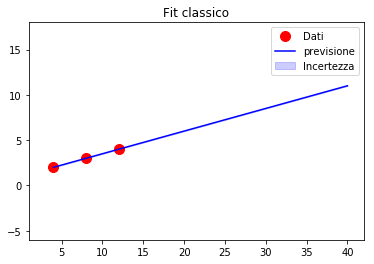

In [89]:
from scipy.optimize  import curve_fit
from utils import calc_sup_inf
def lin_c(x, p0, p1=None):
    if p1 is None:
        return p0[0] + x * p0[1]
    else:
        return p0+x*p1
plt.plot(x,y, 'o', markersize=10, label = "Dati", color = 'r')

pfit, pcov = curve_fit(lin_c, x, y)
perr = np.sqrt(np.diagonal(pcov))

x_xtd = np.array([4, 8, 40])
y_xtd = lin_c(x_xtd, pfit[0], pfit[1])

sup, inf = calc_sup_inf(lin_c, x_xtd, pfit, perr)
plt.fill_between(x_xtd, sup, inf, label = "Incertezza", color = 'b', alpha = 0.2)

plt.plot(x_xtd, y_xtd, label = "previsione" , color = 'b')
plt.legend()
plt.title("Fit classico")
plt.xlim(1, 42)
plt.ylim(-6, 18)

In [92]:
x_shared = shared(x)


with pm.Model() as model:
    lin_a = pm.Normal('lin_a', 2.,5.)
    lin_b = pm.Normal('lin_b', 0.2,1.)
    
    equation = lin_a + x_shared * lin_b
    
    eps = pm.HalfCauchy("eps", beta=20)
    
    pm.Normal("like", equation, eps, observed=y)

    trace = pm.sample(cores=2, target_accept=0.99)
    
    post_pred = pm.sample_posterior_predictive(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, lin_b, lin_a]
Sampling 2 chains, 16 divergences: 100%|██████████| 2000/2000 [00:26<00:00, 74.95draws/s] 
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9604069408441684, but should be close to 0.99. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9451375994400921, but should be close to 0.99. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:02<00:00, 365.54it/s]


In [93]:
# x_shared.set_value(np.linspace(-1, 20, 100))
newx = np.array([4., 8., 40.])
x_shared.set_value(newx)
post_pred_new = pm.sample_posterior_predictive(trace, model=model ,samples=100000)

100%|██████████| 100000/100000 [02:08<00:00, 776.25it/s]


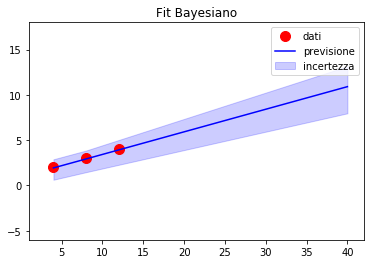

In [95]:
plt.plot(x, y, 'o', markersize=10, color='r', label = "dati")
y_fitted, y_fitted_sup, y_fitted_inf = calc_sup_inf_bay(post_pred_new['like'])

plt.plot(newx,y_fitted, color='b', label='previsione')
plt.fill_between(newx,y_fitted_sup, y_fitted_inf, color='b', alpha = 0.2, label='incertezza')

plt.ylim(-10, 30)
plt.title("Fit Bayesiano")
plt.xlim(1, 42)
plt.ylim(-6, 18)
plt.legend()

# previsione casi totali al 13 Marzo

In [2]:
df = pd.read_csv("COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
df['data'] = pd.to_datetime(df['data'])
data_limite_sup = pd.to_datetime("2020-03-13T20:00")
df=df[df['data']<data_limite_sup]
#data_limite_inf = pd.to_datetime("2020-02-28T10:00")
#df=df[df['data']>data_limite_inf]
df.index=df['data']


In [3]:
x = np.arange(len(df))
x_shared = shared(x)

y = df['totale_casi'].values

# creiamo il modello aiutandoci con PyMC3
with pm.Model() as model:
    
    # Distribuzioni 'a priori' 
    plateau = pm.Normal("plateau", mu=90000, sigma=20000)
    
    flesso = pm.Normal("flesso", mu=23, sigma=5)
    
    crescita = pm.Normal("crescita", mu=0.19, sigma=0.1)
    
    # formula descrivente il modello
    sigmoid = plateau / (1 + np.exp(-(x_shared-flesso)*crescita))
    
    eps = pm.HalfNormal("err")
    
    # Likelihood: quanto le condizioni a priori soddisfano il modello, considerando i dati
    pm.Lognormal("L_italia", np.log(sigmoid), eps, observed=y)
    
    # modellazione con MCMC
    trace = pm.sample(tune=20000, target_accept=0.99, chains=2)
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [err, crescita, flesso, plateau]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [09:35<00:00, 71.21draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


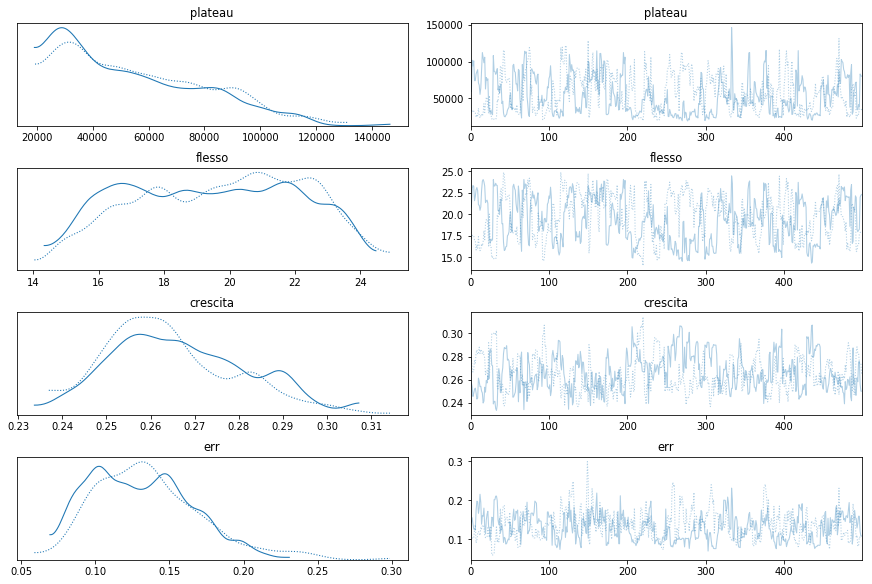

In [4]:
pm.traceplot(trace)
plt.show()

In [5]:
x_extension = 3
x_new = np.arange(x_extension*len(df))
x_shared.set_value(x_new)
post_pred = pm.sample_posterior_predictive(trace, model=model,samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 456.85it/s]


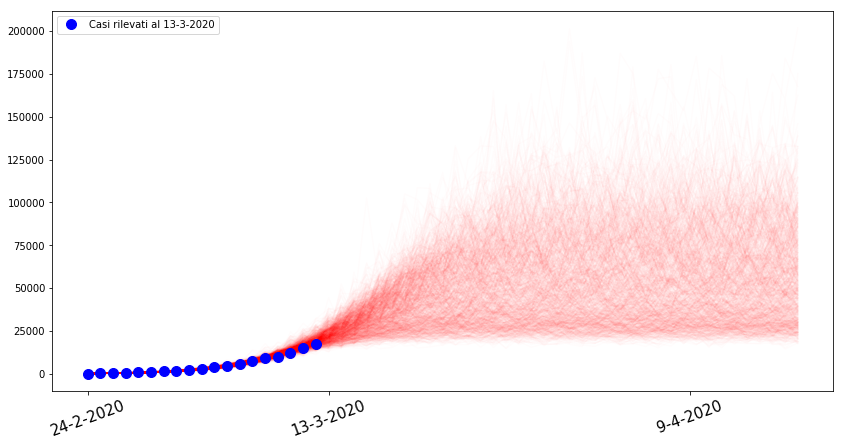

In [6]:
plt.figure(figsize=(14,7))
#plt.plot(x_new[len(df):], post_pred['L_italia'].T[len(df):], color='r', alpha=.01)
plt.plot(post_pred['L_italia'].T, color='r', alpha=.01)

data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
plt.plot(x,y, 'o', color='b', markersize=10, label = f"Casi rilevati al {data_rilev}")

data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
terzo_tick = df.index[-1] + 1.5*(df.index[-1]-df.index[0])
terzo_tick2print = str(terzo_tick.day) + "-" + str(terzo_tick.month) + "-" + str(terzo_tick.year) 
dates2plot = [str(df.index[0].day) + "-" + str(df.index[0].month) + "-" + str(df.index[0].year),
              data_rilev,
              terzo_tick2print
             ]
plt.xticks(ticks=[0, len(df), 2.5*len(df)], labels=dates2plot,rotation=20, size = 15)
plt.legend()
plt.show()

# previsione casi totali al 29 Marzo

In [7]:
df = pd.read_csv("COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
df['data'] = pd.to_datetime(df['data'])
#data_limite_sup = pd.to_datetime("2020-03-13T20:00")
#df=df[df['data']<data_limite_sup]
#data_limite_inf = pd.to_datetime("2020-02-28T10:00")
#df=df[df['data']>data_limite_inf]
df.index=df['data']

In [8]:
x = np.arange(len(df))
x_shared = shared(x)

y = df['totale_casi'].values

# creiamo il modello aiutandoci con PyMC3
with pm.Model() as model:
    
    # Distribuzioni 'a priori' 
    plateau = pm.Normal("plateau", mu=90000, sigma=20000)
    
    flesso = pm.Normal("flesso", mu=23, sigma=5)
    
    crescita = pm.Normal("crescita", mu=0.19, sigma=0.1)
    
    # formula descrivente il modello
    sigmoid = plateau / (1 + np.exp(-(x_shared-flesso)*crescita))
    
    eps = pm.HalfNormal("err")
    
    # Likelihood: quanto le condizioni a priori soddisfano il modello, considerando i dati
    pm.Lognormal("L_italia", np.log(sigmoid), eps, observed=y)
    
    # modellazione con MCMC
    trace = pm.sample(tune=20000, target_accept=0.99, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [err, crescita, flesso, plateau]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [02:37<00:00, 260.53draws/s]


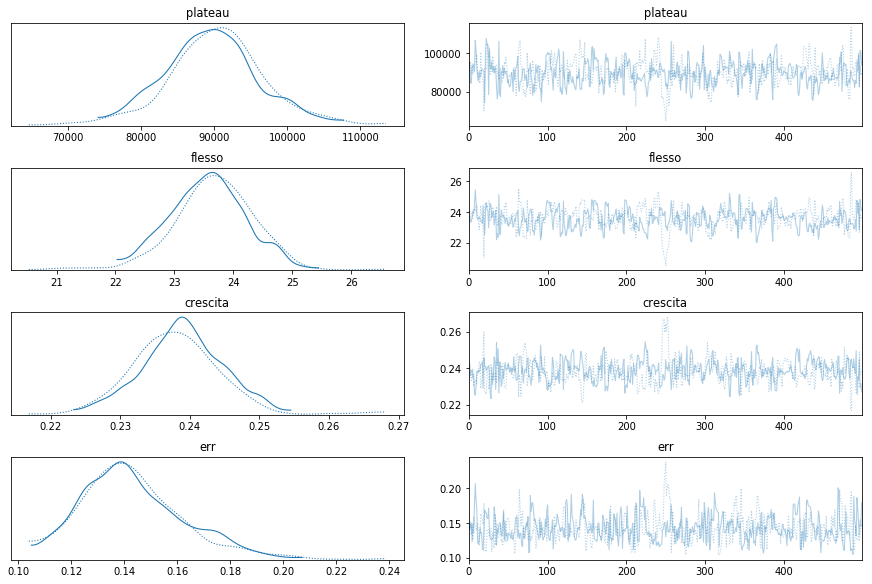

In [9]:
pm.traceplot(trace)
plt.show()

In [10]:
x_extension = 3
x_new = np.arange(x_extension*len(df))
x_shared.set_value(x_new)
post_pred = pm.sample_posterior_predictive(trace, model=model,samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 479.52it/s]


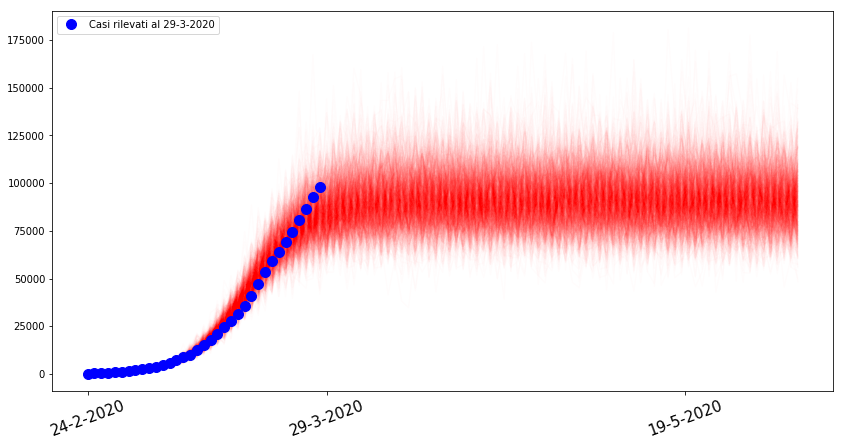

In [11]:
plt.figure(figsize=(14,7))
#plt.plot(x_new[len(df):], post_pred['L_italia'].T[len(df):], color='r', alpha=.01)
plt.plot(post_pred['L_italia'].T, color='r', alpha=.01)

data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
plt.plot(x,y, 'o', color='b', markersize=10, label = f"Casi rilevati al {data_rilev}")

data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
terzo_tick = df.index[-1] + 1.5*(df.index[-1]-df.index[0])
terzo_tick2print = str(terzo_tick.day) + "-" + str(terzo_tick.month) + "-" + str(terzo_tick.year) 
dates2plot = [str(df.index[0].day) + "-" + str(df.index[0].month) + "-" + str(df.index[0].year),
              data_rilev,
              terzo_tick2print
             ]
plt.xticks(ticks=[0, len(df), 2.5*len(df)], labels=dates2plot,rotation=20, size = 15)
plt.legend()
plt.show()

# Gompertz

In [54]:
x = np.arange(len(df))/10
x_shared = shared(x)

y = df['totale_casi'].values

# creiamo il modello aiutandoci con PyMC3
with pm.Model() as model:
    
    # Distribuzioni 'a priori' 

    offset = pm.Normal("offset", mu=0, sigma=2000)
    par0 =  pm.Normal("par0", mu=2.6e+05, sigma=2.6e+03)
    par1 =  pm.Normal("par1", mu=1.2, sigma=1)
    par2 =  pm.Normal("par2", mu=0.6, sigma=1)
    par3 =  pm.Normal("par3", mu=3.2, sigma=5)

    gompertz = offset + par0* np.exp(-par1*np.exp(-par2*(x_shared-par3)))
    
    eps = pm.HalfNormal("err")
    
    # Likelihood: quanto le condizioni a priori soddisfano il modello, considerando i dati
    #pm.Lognormal("L_italia", np.log(sigmoid), eps, observed=y)
    pm.Lognormal("L_italia", np.log(gompertz), eps, observed=y)
    
    # modellazione con MCMC
    trace = pm.sample(tune=2000, target_accept=0.99, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [err, par3, par2, par1, par0, offset]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [07:02<00:00, 11.82draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
x_extension = 3
x_new = np.arange(x_extension*len(df)/10)
x_shared.set_value(x_new)
post_pred = pm.sample_posterior_predictive(trace, model=model,samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 455.43it/s]


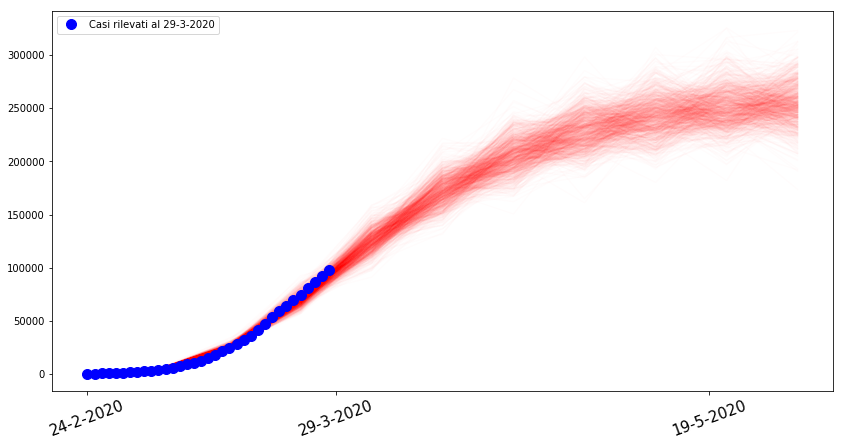

In [57]:
plt.figure(figsize=(14,7))
#plt.plot(x_new[len(df):], post_pred['L_italia'].T[len(df):], color='r', alpha=.01)
plt.plot(post_pred['L_italia'].T, color='r', alpha=.01)

data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
plt.plot(x,y, 'o', color='b', markersize=10, label = f"Casi rilevati al {data_rilev}")

data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
terzo_tick = df.index[-1] + 1.5*(df.index[-1]-df.index[0])
terzo_tick2print = str(terzo_tick.day) + "-" + str(terzo_tick.month) + "-" + str(terzo_tick.year) 
dates2plot = [str(df.index[0].day) + "-" + str(df.index[0].month) + "-" + str(df.index[0].year),
              data_rilev,
              terzo_tick2print
             ]
plt.xticks(ticks=[0, len(df)/10, 2.5*len(df)/10], labels=dates2plot,rotation=20, size = 15)
plt.legend()
plt.show()